In [19]:
%load_ext autoreload
%autoreload 2

import os, glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib as mpl
mpl.rc('image', cmap='inferno')

import models.model_2d as mod
import models.layers as lay
import forward_model as fm
import utils as ut

# Gradually adding stuff to find the culprit of memory issues
import sys
import io
import json
from os import path
import imageio
from scipy.ndimage import gaussian_filter
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

os.environ["CUDA_VISIBLE_DEVICES"]="1" 

In [2]:
filter_init_path = '../data/multiWienerPSFStack_40z_aligned.mat' # initialize with 9 PSFs
filter_key = 'multiWienerPSFStack_40z'  # key to load in

In [3]:
registered_psfs_path = filter_init_path
psfs = scipy.io.loadmat(registered_psfs_path)
psfs=psfs[filter_key]

psfs=psfs[:,:,:,0]
psfs=psfs/np.max(psfs)

Ks =np.ones((1,1,9))

model3 =mod.UNet_multiwiener_resize(486, 648, psfs, Ks, 
                     encoding_cs=[24, 64, 128, 256, 512, 1024],
                     center_cs=1024,
                     decoding_cs=[512, 256, 128, 64, 24, 24],
                     skip_connections=[True, True, True, True, True, False])

print('initialized filter shape:', psfs.shape, 'initialized K shape:', Ks.shape)

initialized filter shape: (486, 648, 9) initialized K shape: (1, 1, 9)


In [4]:
model3.build((None, 486, 648, 1))

In [6]:
restarget=scipy.io.loadmat('../data/real_data/resTargetZ_1.mat')
restarget=restarget['b']

In [7]:
recon3=model3.predict(restarget.reshape((1,486, 648,1)))

1/1 [==============================] - 6s 6s/step


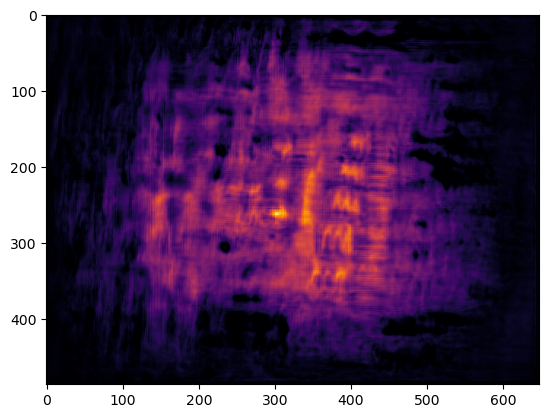

In [9]:
plt.imshow(recon3[0])

In [11]:
recon3.shape

(1, 486, 648)

In [20]:
def MultiWienerProbe(height, width, initial_psfs, initial_Ks):
    inputs = tf.keras.Input((height, width, 1))
    
    x = inputs
    
    # Multi-Wiener deconvolutions
    x = lay.MultiWienerDeconvolution(initial_psfs, initial_Ks)(x)
    print(x.shape)
    model = tf.keras.Model(inputs=[inputs], outputs=[x])
    
    return model


In [21]:
multiwiener =MultiWienerProbe(486, 648, psfs, Ks)

(None, 486, 648, 9)


Hmmm... seems like `tf.keras.Input` has an extra `None` dimension, which is broadcasted to and ignored throughout all the operations in `MultiWienerDeconvolution`. This means that the output from this built network also has an extra `None` dimension. However, the next experiments make this 'hmmm' even 'hmmmm'-ier...

In [22]:
multiwiener.build((None, 486, 648, 1))

In [23]:
recon4=multiwiener.predict(restarget.reshape((1,486, 648,1)))

1/1 [==============================] - 0s 199ms/step


In [24]:
recon4.shape

(1, 486, 648, 9)

**More hmmmm:** When `tf.keras.Model.predict()` is called, the output of it has a 1 instead of `None` in that extra dimension.

In [27]:
recon5=multiwiener.predict(tf.constant([restarget.reshape((486, 648,1)), restarget.reshape((486, 648,1))]))

1/1 [==============================] - 0s 80ms/step


In [28]:
recon5.shape

(2, 486, 648, 9)

Things make sense now. The `None` represents that we can pass an arbitrarily large array (the entire construct amounting to a 4-dimensional `tf.Tensor`) of these images of size `(486, 648, 1)`. 